# Possession/Actions heat map chart

In this tutorial, I'm going to cover creating a possession or an action concentration heat map such as the one in the example below.

![heatmap image](../images/heatmap_image.png)

The color concentration on this map demonstrates which team had a dominant share of actions in each area of the pitch, with blank areas being areas where teams had about equal share of possession.

## Data Loading

The data needed for this is actually extremely simple.  I just need coordinates of events and an indicator of which team each event is associated with.  To simplify things visually, I also added the team name, but that's acutally unnecessary and isn't used anywhere.  For this, I load a dataframe with the following columns

- x: the x location of the event
- y: the y location of the event
- team: team name 
- is_home_team: whether the event is associated with the home team or the away team

In [44]:
import pandas as pd

data = pd.read_csv('../data/heatmap.csv', index_col=None)
data.head()

,x,y,team,is_home_team
0,49.7,49.9,man city,0
1,24.1,44.0,man city,0
2,5.1,46.7,arsenal,1
3,57.9,2.8,arsenal,1
4,32.6,92.4,man city,0


## Data Transformation

The data transformation here is pretty simple. Later on, I'm going to be using a built in `mplsoccer` function to 'bin' events in pre-set areas of the pitch and I'm going to sum the total quantity of events in each bin from one team, and subtract the events from the other team, to calculate the net balance of events across the two teams.  So I have to make sure that our indicator variable that I'm going to be summing is positive for one team and negative for another.  I will create a new column, `possessoin_side` that does that.  Additionally, the data for both teams is referenced with X=0 being their goalline, so in order to create a heatmap where each team's events are properly aligned with their respective goals, I need to flip both the x and y coordinates of one of the teams.

In [45]:
def transform_data(data):
    data = data.copy()
    data['possession_side'] = data['is_home_team'].apply(lambda x: 1 if x == 1 else -1)
    data['x'] = data.apply(lambda x: x['x'] if x['possession_side'] == 1 else 100 - x['x'], axis=1)
    data['y'] = data.apply(lambda x: x['y'] if x['possession_side'] == 1 else 100 - x['y'], axis=1)
    return data

## Visualising the data

First thing first, I'm going to create a custom color map for this.  This color map will transition from non-transparent away color, to fully transparent color in the middle of the palette to non-transparent home color

In [46]:
home_color = (239, 1, 7) #arsenal red
away_color = (108, 171, 221) #man city blue

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(
    'mycmap', 
    [
        (0, (away_color[0]/256, away_color[1]/256, away_color[2]/256, 0.9)), #slightly transparent away color
        (0.499, (away_color[0]/256, away_color[1]/256, away_color[2]/256, 0.0)), #fully transparent away color
        
        (0.501, (home_color[0]/256, home_color[1]/256, home_color[2]/256, 0.0)), # fully transparent home color
        (1, (home_color[0]/256, home_color[1]/256, home_color[2]/256, 0.9)) # slightly transparent home color
    ]
)

Next, I am going to use the `mplsoccer` `bin_statistic` function to split the data into bins, summing the `possession_side` variable, and then draw the heatmap using the `heatmap` function

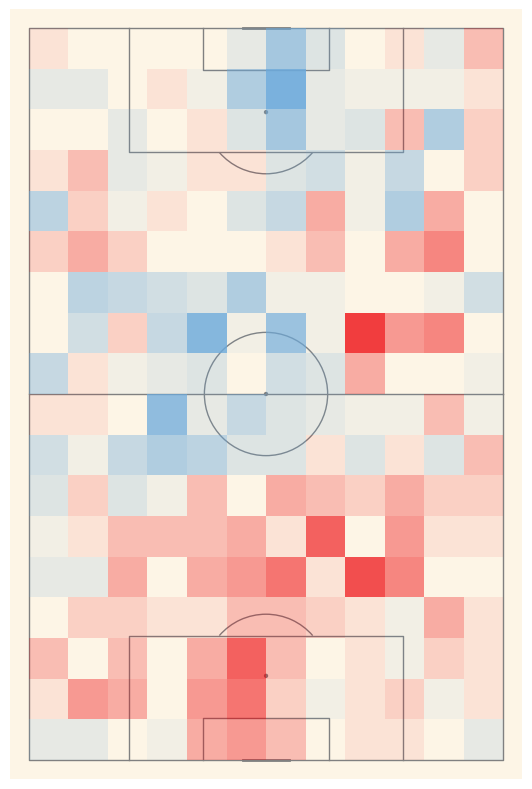

In [47]:
%matplotlib inline
from mplsoccer.pitch import VerticalPitch


data_transformed = transform_data(data)

pitch = VerticalPitch(pitch_type='opta', pitch_color='oldlace',line_color='grey',linewidth=1)
bins = pitch.bin_statistic(data_transformed['x'], data_transformed['y'], values = data_transformed['possession_side'], statistic='sum', bins = (18, 12))
max_abs_value = max([abs(bins['statistic'].min()), bins['statistic'].max()])
fig, ax = pitch.draw(figsize=(6,8))
pitch.heatmap(bins, edgecolors = 'white', ax = ax, cmap=cmap, lw=0, vmin=-max_abs_value, vmax=max_abs_value)

fig;


Ok, so this didn't work out at all.  The bins sort of indicates what I want, but they're far too coarse and also full of holes in some cases. This is giving us some idea where each team dominated but its hard to process visually because of how uneven this is.  I need to smooth it out.

The solution is to convolve the heatmap using two functions provided by the `scipy.ndimage function`.  The first function is `gaussian_filter` smoothes out the bins by essentially taking each bin and averaging it with its neighbours to create smoother transitions. The second function is the `zoom` function which takes the bin array and breaks it down into smaller segments, applying an interpolation to keep things smooth.

However, as it turns out, the easiest place to apply these filters is while calculating the bins.  The `mplsoccer` library has incredible code for creating these bins and returning them in the format that's ready for heatmapping.  The easiest way to apply `gaussian_filter` and `zoom` is inside the function.  `mplsoccer` is authored by Andy Rowlinson (twitter: [@mplsoccer_dev](https://x.com/mplsoccer_dev), bluesky: [@numberstorm.bsky.social](https://bsky.app/profile/numberstorm.bsky.social)).  For convenience of this demo, I simply copied his binning code into this repository in [util_code/bin_statistic.py](util_code/bin_statistic.py).  My only addition have been the following lines to apply `gaussian_filter` and `zoom`
```
    if gaussian_filter_value is not None:
        statistic = gaussian_filter(statistic, gaussian_filter_value)
    if zoom_value is not None:
        statistic = zoom(statistic, zoom_value)
        x_edge = np.linspace(x_edge[0], x_edge[-1], int(bins[0] * zoom_value) + 1)
        y_edge = np.linspace(y_edge[0], y_edge[-1], int(bins[1] * zoom_value) + 1)
        # Determine the bin indices in the new grid for each data point
        x_bin_indices = np.digitize(x, x_edge) - 1  # `-1` to match zero-based indexing
        y_bin_indices = np.digitize(y, y_edge) - 1
        binnumber = np.array([x_bin_indices, y_bin_indices])
```

the credit for making these displays possible, though, goes entirely to Andy.  If he decides to incorporate my changes into his library directly, I'll change this example to use his code.

Anyway, with this explanation out of the way, what does the end result looks like?

Quite nice, actually

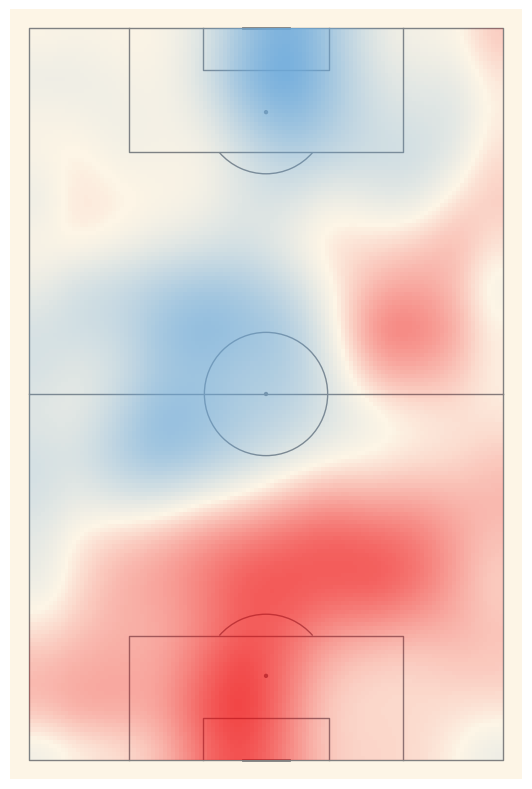

In [48]:
%matplotlib inline
from mplsoccer.pitch import VerticalPitch
from util_code.bin_statistic import bin_statistic # use local version of bin_statistic

data_transformed = transform_data(data)

pitch = VerticalPitch(pitch_type='opta', pitch_color='oldlace',line_color='grey',linewidth=1)
bins = bin_statistic(data_transformed['x'], data_transformed['y'], values = data_transformed['possession_side'], statistic='sum', bins = (18, 12), dim=pitch.dim, gaussian_filter_value=1, zoom_value=10 )
max_abs_value = max([abs(bins['statistic'].min()), bins['statistic'].max()])
fig, ax = pitch.draw(figsize=(6,8))
pitch.heatmap(bins, edgecolors = 'white', ax = ax, cmap=cmap, lw=0, vmin=-max_abs_value, vmax=max_abs_value)

fig;
